In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, assemble, transpile, Aer, IBMQ
# from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *
# from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy
from qiskit import execute

from qiskit.tools.monitor import job_monitor

from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit import QuantumRegister
from qiskit.visualization import array_to_latex

# Loading your IBM Quantum account(s)

/tmp/ipykernel_1507/83197244.py:14: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
# provider = IBMQ.get_provider(hub='ibm')
real_backend = least_busy(provider.backends(filters=lambda x: not x.configuration().simulator))
# real_backend = provider.get_backend('ibm_lagos')
print("backend used: ", real_backend)

backend used:  ibmq_belem


In [3]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    oracle_qc.name = "oracle " + case
    return oracle_qc
    # oracle_gate = oracle_qc.to_gate()
    # oracle_gate.name = "Oracle" # To show when we display the circuit
    # return oracle_gate

In [4]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    # dj_circuit.barrier()
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    # dj_circuit.barrier()
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [5]:
n = 3

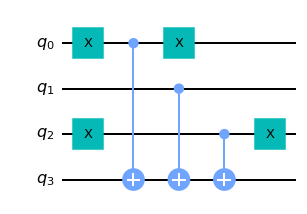

In [21]:
oracle_qc = dj_oracle('balanced', n)
oracle_qc.draw()

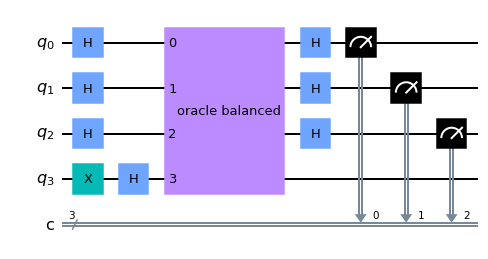

In [22]:
dj_circuit = dj_algorithm(oracle_qc, n)
dj_circuit.draw()

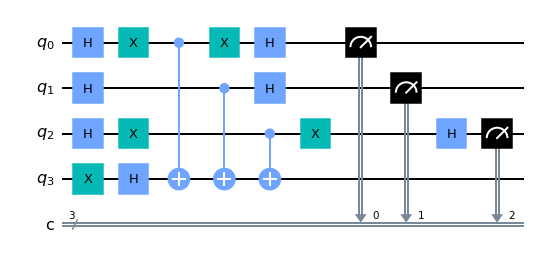

In [23]:
new_dj = dj_circuit.decompose('oracle balanced')

new_dj.draw()

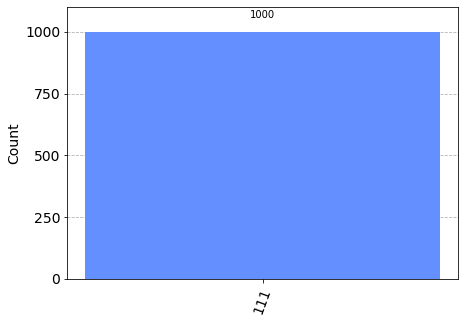

In [24]:
aer_backend = Aer.get_backend('aer_simulator')
aer_job = execute(dj_circuit, aer_backend, shots=1000)
aer_results = aer_job.result()
aer_counts = aer_results.get_counts()
plot_histogram(aer_counts)

In [25]:
job = execute(dj_circuit, real_backend, shots=1000)
realqc_results = job.result()

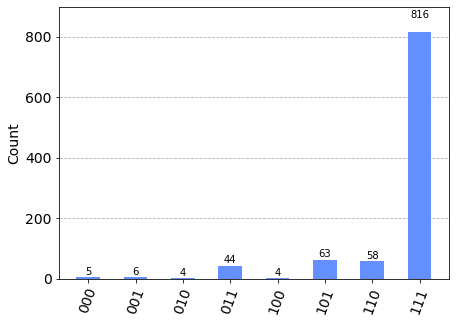

In [26]:
counts = realqc_results.get_counts()
plot_histogram(counts)

In [27]:
# QEM
qr = QuantumRegister(n)
qem_meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
qem_cal_results = real_backend.run(qem_meas_calibs, shots=10000).result()

In [28]:
meas_fitter = CompleteMeasFitter(qem_cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [29]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(realqc_results)
mitigated_counts = mitigated_results.get_counts()

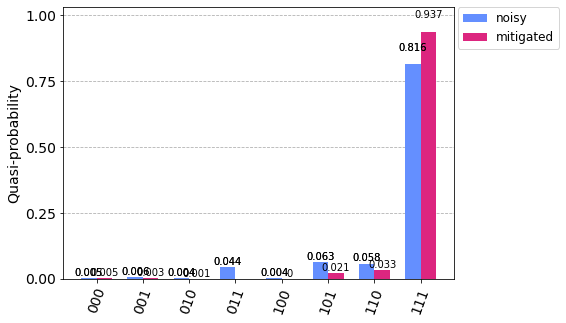

In [30]:
noisy_counts = realqc_results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

In [16]:
# GEM

In [31]:
# not calibrating ancilla
# depends on the concrete DJ circuit: x on 0,2
dj_left0 = QuantumCircuit(n,n)
dj_left1 = QuantumCircuit(n) 
dj_left2 = QuantumCircuit(n)
dj_left3 = QuantumCircuit(n)
dj_left4 = QuantumCircuit(n)
dj_left5 = QuantumCircuit(n)
dj_left6 = QuantumCircuit(n)
dj_left7 = QuantumCircuit(n)

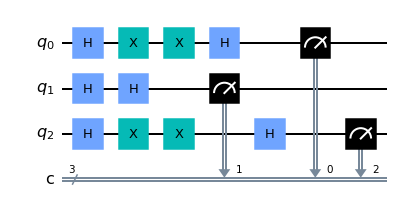

In [32]:
dj_left0.h(0)
dj_left0.x(0)
dj_left0.x(0)
dj_left0.h(0)

dj_left0.h(1)
dj_left0.h(1)

dj_left0.h(2)
dj_left0.x(2)
dj_left0.x(2)
dj_left0.h(2)

dj_left0.measure([0,1,2], [0,1,2])
dj_left0.draw()

/tmp/ipykernel_1507/4218642948.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left1 += dj_left0


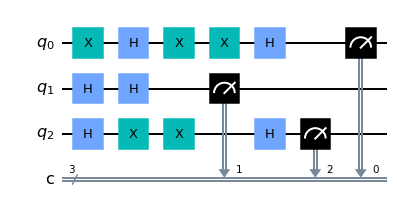

In [33]:
dj_left1.x(0)
dj_left1 += dj_left0
dj_left1.draw()

/tmp/ipykernel_1507/2252380090.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left2 += dj_left0


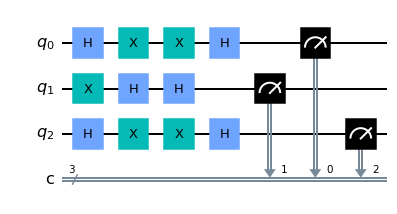

In [34]:
dj_left2.x(1)
dj_left2 += dj_left0
dj_left2.draw()

/tmp/ipykernel_1507/810308772.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left3 += dj_left0


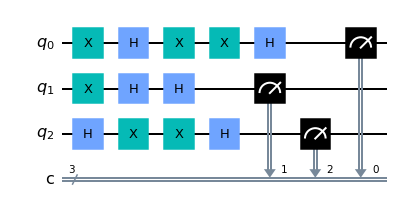

In [35]:
dj_left3.x(0)
dj_left3.x(1)
dj_left3 += dj_left0
dj_left3.draw()

/tmp/ipykernel_1507/264572622.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left4 += dj_left0


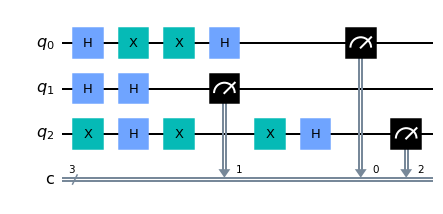

In [36]:
dj_left4.x(2)
dj_left4 += dj_left0
dj_left4.draw()

/tmp/ipykernel_1507/2497025790.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left5 += dj_left0


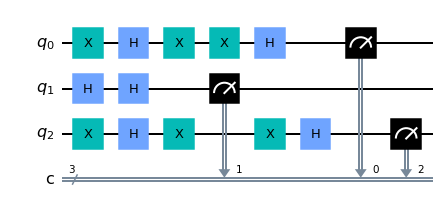

In [37]:
dj_left5.x(2)
dj_left5.x(0)
dj_left5 += dj_left0
dj_left5.draw()

/tmp/ipykernel_1507/2426855407.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left6 += dj_left0


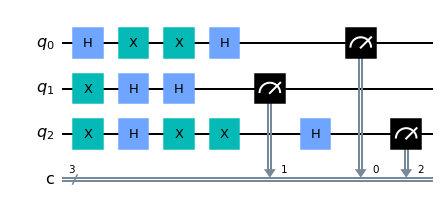

In [38]:
dj_left6.x(2)
dj_left6.x(1)
dj_left6 += dj_left0
dj_left6.draw()

/tmp/ipykernel_1507/778788731.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left7 += dj_left0


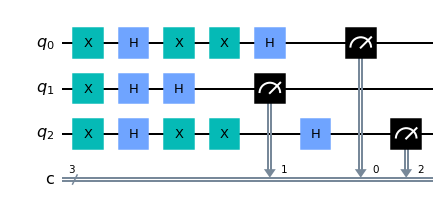

In [39]:
dj_left7.x(2)
dj_left7.x(1)
dj_left7.x(0)
dj_left7 += dj_left0
dj_left7.draw()

In [40]:
meas_calibs1 = [dj_left0, dj_left1, dj_left2, dj_left3, dj_left4, dj_left5, dj_left6, dj_left7]
print(len(meas_calibs1))

8


In [41]:
# t_qc = transpile(meas_calibs1, aer_backend)
# qobj = assemble(t_qc, shots=10000)
# results = aer_backend.run(qobj, shots=10000).result()
# result_counts = results.get_counts()
# print(result_counts)

In [42]:
t_qc = transpile(meas_calibs1, real_backend)
qobj = assemble(t_qc, shots=10000)
real_results_left = real_backend.run(qobj, shots=10000).result()

/tmp/ipykernel_1507/3062128249.py:3: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  real_results_left = real_backend.run(qobj, shots=10000).result()


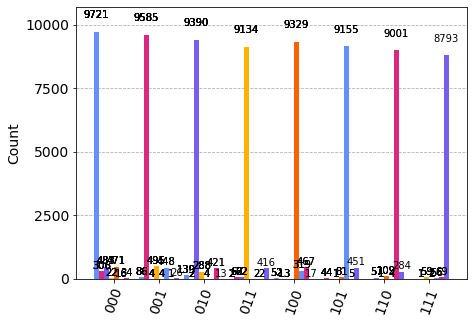

In [43]:
real_counts_left = real_results_left.get_counts()
plot_histogram(real_counts_left)

In [44]:
ls = []
for qc in meas_calibs1:
     counts = real_results_left.get_counts(qc)
     this_array = np.array([counts.get('000') or 0, counts.get('001') or 0, counts.get('010') or 0, counts.get('011') or 0 , counts.get('100') or 0, counts.get('101') or 0, counts.get('110') or 0, counts.get('111') or 0])
     this_array = this_array/10000
     ls.append(this_array)
     print(this_array)
     # np.append(array, this_array, axis=1)
array = np.array(ls)
# print(array)
array_t_left = np.transpose(array)
# print(array_t_left)

[9.721e-01 8.600e-03 1.390e-02 2.000e-04 5.200e-03 0.000e+00 0.000e+00
 0.000e+00]
[3.060e-02 9.585e-01 2.000e-04 6.200e-03 1.000e-04 4.400e-03 0.000e+00
 0.000e+00]
[4.83e-02 4.00e-04 9.39e-01 6.20e-03 3.00e-04 0.00e+00 5.70e-03 1.00e-04]
[2.200e-03 4.950e-02 2.880e-02 9.134e-01 0.000e+00 1.000e-04 1.000e-04
 5.900e-03]
[4.710e-02 4.000e-04 4.000e-04 0.000e+00 9.329e-01 8.100e-03 1.090e-02
 2.000e-04]
[1.600e-03 4.480e-02 0.000e+00 2.000e-04 3.190e-02 9.155e-01 4.000e-04
 5.600e-03]
[3.400e-03 1.000e-04 4.210e-02 2.000e-04 4.670e-02 5.000e-04 9.001e-01
 6.900e-03]
[0.     0.0026 0.0013 0.0416 0.0017 0.0451 0.0284 0.8793]


In [45]:
array_to_latex(array_t_left)

<IPython.core.display.Latex object>

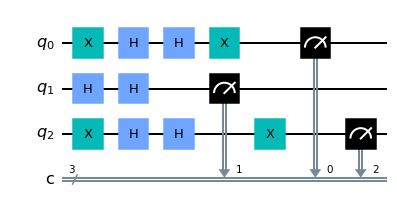

In [46]:
dj_right0 = QuantumCircuit(n,n)
dj_right1 = QuantumCircuit(n) 
dj_right2 = QuantumCircuit(n)
dj_right3 = QuantumCircuit(n)
dj_right4 = QuantumCircuit(n)
dj_right5 = QuantumCircuit(n)
dj_right6 = QuantumCircuit(n)
dj_right7 = QuantumCircuit(n)

dj_right0.x(0)
dj_right0.x(2)
dj_right0.h(0)
dj_right0.h(2)
dj_right0.h(0)
dj_right0.h(2)
dj_right0.x(0)
dj_right0.x(2)
dj_right0.h(1)
dj_right0.h(1)

dj_right0.measure([0,1,2], [0,1,2])
dj_right0.draw()

/tmp/ipykernel_1507/1762657075.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right1 += dj_right0


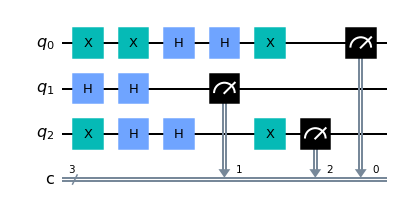

In [47]:
dj_right1.x(0)

dj_right1 += dj_right0

dj_right1.draw()

/tmp/ipykernel_1507/1107241932.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right2 += dj_right0


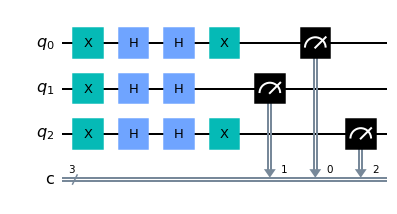

In [48]:
dj_right2.x(1)
dj_right2 += dj_right0
dj_right2.draw()

/tmp/ipykernel_1507/2247627861.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right3 += dj_right0


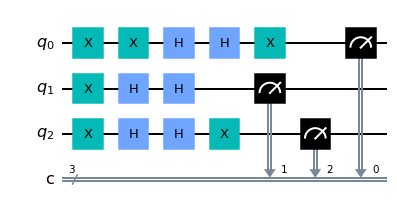

In [49]:
dj_right3.x(0)
dj_right3.x(1)
dj_right3 += dj_right0
dj_right3.draw()

/tmp/ipykernel_1507/35910541.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right4 += dj_right0


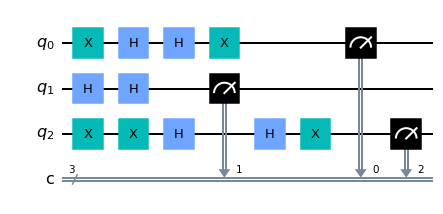

In [50]:
dj_right4.x(2)
dj_right4 += dj_right0
dj_right4.draw()

/tmp/ipykernel_1507/1744533513.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right5 += dj_right0


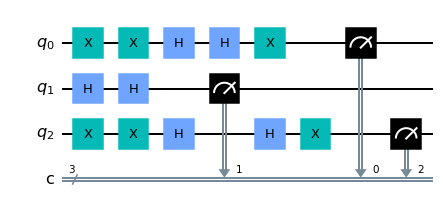

In [51]:
dj_right5.x(2)
dj_right5.x(0)
dj_right5 += dj_right0
dj_right5.draw()

/tmp/ipykernel_1507/1654595449.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right6 += dj_right0


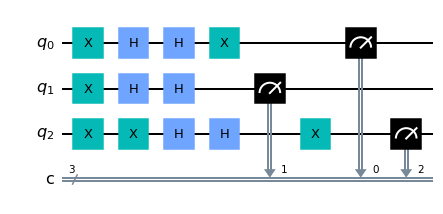

In [52]:
dj_right6.x(2)
dj_right6.x(1)
dj_right6 += dj_right0
dj_right6.draw()

/tmp/ipykernel_1507/611483946.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right7 += dj_right0


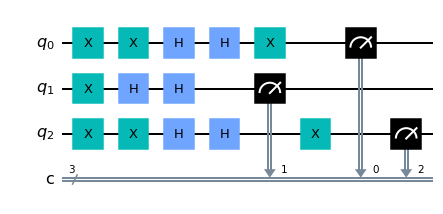

In [53]:
dj_right7.x(2)
dj_right7.x(1)
dj_right7.x(0)
dj_right7 += dj_right0
dj_right7.draw()

In [54]:
meas_calibs2 = [dj_right0, dj_right1, dj_right2, dj_right3, dj_right4, dj_right5, dj_right6, dj_right7]

In [55]:
t_qc = transpile(meas_calibs2, real_backend)
qobj = assemble(t_qc, shots=10000)
results_right = real_backend.run(qobj, shots=10000).result()

In [56]:
result_counts_right = results_right.get_counts()
print(result_counts_right)

[{'000': 9736, '001': 97, '010': 117, '011': 3, '100': 46, '110': 1}, {'000': 305, '001': 9582, '010': 6, '011': 56, '100': 1, '101': 50}, {'000': 558, '001': 3, '010': 9298, '011': 95, '100': 3, '110': 41, '111': 2}, {'000': 20, '001': 493, '010': 290, '011': 9147, '101': 1, '111': 49}, {'000': 392, '001': 5, '010': 6, '100': 9365, '101': 84, '110': 145, '111': 3}, {'000': 11, '001': 403, '011': 3, '100': 289, '101': 9223, '110': 4, '111': 67}, {'000': 25, '010': 428, '011': 5, '100': 509, '101': 6, '110': 8938, '111': 89}, {'000': 1, '001': 29, '010': 11, '011': 385, '100': 22, '101': 495, '110': 304, '111': 8753}]


In [57]:
ls = []
for qc in meas_calibs2:
     counts = results_right.get_counts(qc)
     this_array = np.array([counts.get('000') or 0, counts.get('001') or 0, counts.get('010') or 0, counts.get('011') or 0 , counts.get('100') or 0, counts.get('101') or 0, counts.get('110') or 0, counts.get('111') or 0])
     this_array = this_array/10000
     ls.append(this_array)
     print(this_array)
array = np.array(ls)

array_t_right = np.transpose(array)
print(array_t_right)

[9.736e-01 9.700e-03 1.170e-02 3.000e-04 4.600e-03 0.000e+00 1.000e-04
 0.000e+00]
[3.050e-02 9.582e-01 6.000e-04 5.600e-03 1.000e-04 5.000e-03 0.000e+00
 0.000e+00]
[5.580e-02 3.000e-04 9.298e-01 9.500e-03 3.000e-04 0.000e+00 4.100e-03
 2.000e-04]
[2.000e-03 4.930e-02 2.900e-02 9.147e-01 0.000e+00 1.000e-04 0.000e+00
 4.900e-03]
[3.920e-02 5.000e-04 6.000e-04 0.000e+00 9.365e-01 8.400e-03 1.450e-02
 3.000e-04]
[1.100e-03 4.030e-02 0.000e+00 3.000e-04 2.890e-02 9.223e-01 4.000e-04
 6.700e-03]
[2.500e-03 0.000e+00 4.280e-02 5.000e-04 5.090e-02 6.000e-04 8.938e-01
 8.900e-03]
[1.000e-04 2.900e-03 1.100e-03 3.850e-02 2.200e-03 4.950e-02 3.040e-02
 8.753e-01]
[[9.736e-01 3.050e-02 5.580e-02 2.000e-03 3.920e-02 1.100e-03 2.500e-03
  1.000e-04]
 [9.700e-03 9.582e-01 3.000e-04 4.930e-02 5.000e-04 4.030e-02 0.000e+00
  2.900e-03]
 [1.170e-02 6.000e-04 9.298e-01 2.900e-02 6.000e-04 0.000e+00 4.280e-02
  1.100e-03]
 [3.000e-04 5.600e-03 9.500e-03 9.147e-01 0.000e+00 3.000e-04 5.000e-04
  3.850e-

In [58]:
array_to_latex(array_t_right)

<IPython.core.display.Latex object>

In [59]:
array_sum = (array_t_left + array_t_right) / 2
array_to_latex(array_sum)

<IPython.core.display.Latex object>

In [60]:
import scipy.linalg as la
array_inv = la.inv(array_sum)
array_to_latex(array_inv)

<IPython.core.display.Latex object>

In [61]:
counts = realqc_results.get_counts()
result_array = np.array([counts.get('000') or 0, counts.get('001') or 0, counts.get('010') or 0, counts.get('011') or 0 , counts.get('100') or 0, counts.get('101') or 0, counts.get('110') or 0, counts.get('111') or 0])
result_array = result_array/1000

In [62]:
result_array

array([0.005, 0.006, 0.004, 0.044, 0.004, 0.063, 0.058, 0.816])

In [63]:
mitigated = np.dot(array_inv, result_array)

In [64]:
array_to_latex(mitigated)

<IPython.core.display.Latex object>

In [65]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
normal = NormalizeData(mitigated)

In [66]:
array_to_latex(normal)

<IPython.core.display.Latex object>

In [67]:
def Normalize(arr):
    return arr/sum(arr)

In [68]:
new_normal = Normalize(mitigated)

In [69]:
array_to_latex(new_normal)

<IPython.core.display.Latex object>